# Setup

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D

# Read Data as Numpy Array

In [3]:
# load train and test data
training_data = np.load("Data/training_data.npy", allow_pickle=True)
validation_data = np.load("Data/validation_data.npy", allow_pickle=True)
print("training data shape: {}".format(training_data.shape))
print("validation data shape: {}".format(validation_data.shape))

training data shape: (170, 2)
validation data shape: (158, 2)


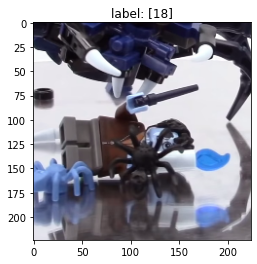

In [5]:
# plot example image
plt.imshow(training_data[10][0])
plt.title("label: {}".format(training_data[10][1]));

In [6]:
X_train = np.array([i[0] for i in training_data])
y_train = np.array([i[1][0] for i in training_data])
X_valid = np.array([i[0] for i in validation_data])
y_valid = np.array([i[1][0] for i in validation_data])

# Prepare Data for Training

In [7]:
# augment and normalize data

# create data generator
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=10)
valid_datagen = ImageDataGenerator(rescale=1./255)

# create an iterator for the datasets.
# the iterator will return one batch of augmented images for each iteration
epochs = 100
batch_size = 20
IMG_SIZE = 224
total_train = X_train.shape[0]
total_valid = X_valid.shape[0]

iter_train = train_datagen.flow(X_train, y_train, batch_size=batch_size,
                                shuffle=True)
iter_valid = train_datagen.flow(X_valid, y_valid, batch_size=batch_size)

# Define the Model

In [10]:
# use pretrained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE,IMG_SIZE,3),
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 2s 0us/step


In [11]:
# freeze model
base_model.trainable = False

In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [16]:
# Add a global spatial average pooling layer
model = Sequential([base_model,
                    BatchNormalization(),
                    Dropout(0.2),
                    GlobalAveragePooling2D(),
                    Dropout(0.4),
                    Dense(30, activation='softmax')    
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 1280)        5120      
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 1280)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 30)                38430     
Total params: 2,301,534
Trainable params: 40,990
Non-trainable params: 2,260,544
_________________________________________

# Train the Model

In [17]:
# compile the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# train the model
history = model.fit(
    iter_train,
    steps_per_epoch=200,#total_train // batch_size,
    epochs=epochs,
    validation_data=iter_valid,
    validation_steps=total_valid // batch_size,
    callbacks=[callback]
)

Epoch 1/100
200/200 [==============================] - 108s 539ms/step - loss: 2.9124 - accuracy: 0.7312 - val_loss: 2.9550 - val_accuracy: 0.6286
Epoch 2/100
200/200 [==============================] - 110s 551ms/step - loss: 2.5312 - accuracy: 0.9802 - val_loss: 2.8281 - val_accuracy: 0.7571
Epoch 3/100
200/200 [==============================] - 181s 907ms/step - loss: 2.4872 - accuracy: 0.9905 - val_loss: 2.7653 - val_accuracy: 0.8000
Epoch 4/100
200/200 [==============================] - 252s 1s/step - loss: 2.4776 - accuracy: 0.9918 - val_loss: 2.8169 - val_accuracy: 0.7571
Epoch 5/100
200/200 [==============================] - 302s 2s/step - loss: 2.4707 - accuracy: 0.9939 - val_loss: 2.8133 - val_accuracy: 0.6929
Epoch 6/100
200/200 [==============================] - 314s 2s/step - loss: 2.4683 - accuracy: 0.9942 - val_loss: 2.7854 - val_accuracy: 0.7429


# Plot Results

In [19]:
def plot_acc_loss(acc, val_acc, loss, val_loss):

    epochs_range = range(len(history.history['loss']))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, color="#58D68D", linewidth=2, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, color="#F1C40F", linewidth=2, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.ylim(0,1)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, color="#58D68D", linewidth=2, label='Training Loss')
    plt.plot(epochs_range, val_loss, color="#F1C40F", linewidth=2, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

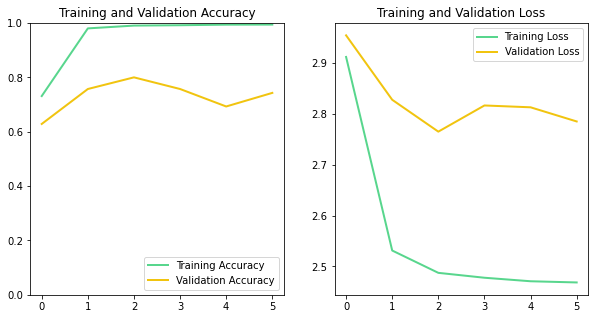

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plot_acc_loss(acc, val_acc, loss, val_loss)

# Plot some example Predictions

In [21]:
sample_test_images, sample_test_labels = next(iter_valid)
predictions = model.predict(sample_test_images)

In [22]:
print("SOME PREDICTIONS:")
for i in range(5,10):
    print("-"*20)
    print("Predicted cell type of the first image: {}.".format(np.argmax(predictions[i])))
    print("True label: {}".format(int(sample_test_labels[i])))

SOME PREDICTIONS:
--------------------
Predicted cell type of the first image: 25.
True label: 25
--------------------
Predicted cell type of the first image: 22.
True label: 22
--------------------
Predicted cell type of the first image: 9.
True label: 9
--------------------
Predicted cell type of the first image: 28.
True label: 28
--------------------
Predicted cell type of the first image: 2.
True label: 2


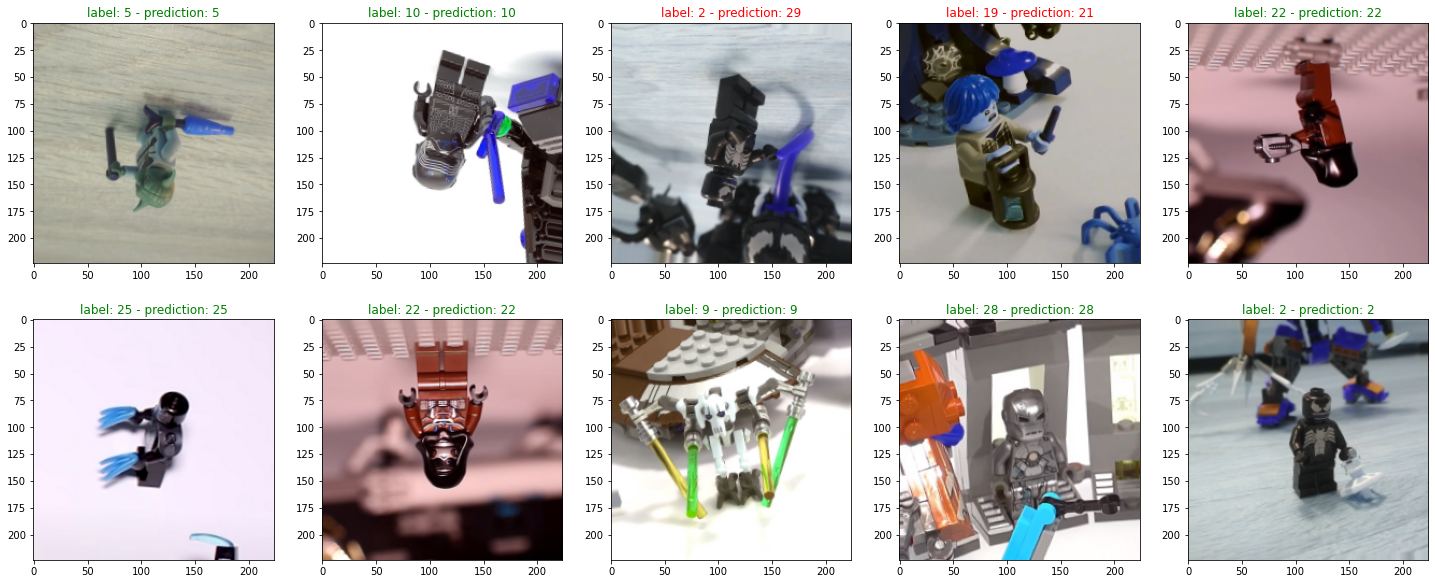

In [23]:
fig, axes = plt.subplots(2,5, figsize=(25,10))

for i, ax in enumerate(axes.flatten()):

    
    ax.imshow(sample_test_images[i])
    ax.set_title(f'label: {sample_test_labels[i].item()} - prediction: {np.argmax(predictions[i])}', 
                color=("green" if np.argmax(predictions[i])==sample_test_labels[i].item() else "red"))

# Define and compare a second Model

In [24]:
# define a second model with end from previous notebook
model1 = Sequential([base_model,
                    #BatchNormalization(),
                    #Dropout(0.2),
                    Flatten(),
                    #Dropout(0.4),
                    Dense(512, activation='relu'), 
                    Dense(30, activation='softmax')    
])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               32113152  
_________________________________________________________________
dense_2 (Dense)              (None, 30)                15390     
Total params: 34,386,526
Trainable params: 32,128,542
Non-trainable params: 2,257,984
_________________________________________________________________


In [25]:
# compile the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
# train the model
history = model1.fit(
    iter_train,
    steps_per_epoch=200,#total_train // batch_size,
    epochs=epochs,
    validation_data=iter_valid,
    validation_steps=total_valid // batch_size,
    callbacks=[callback]
)

Epoch 1/100
200/200 [==============================] - 122s 612ms/step - loss: 3.4156 - accuracy: 0.0413 - val_loss: 3.4207 - val_accuracy: 0.0362
Epoch 2/100
200/200 [==============================] - 174s 872ms/step - loss: 3.4167 - accuracy: 0.0402 - val_loss: 3.4207 - val_accuracy: 0.0362
Epoch 3/100
200/200 [==============================] - 274s 1s/step - loss: 3.4151 - accuracy: 0.0418 - val_loss: 3.4207 - val_accuracy: 0.0362
Epoch 4/100
200/200 [==============================] - 290s 1s/step - loss: 3.4155 - accuracy: 0.0414 - val_loss: 3.4207 - val_accuracy: 0.0362


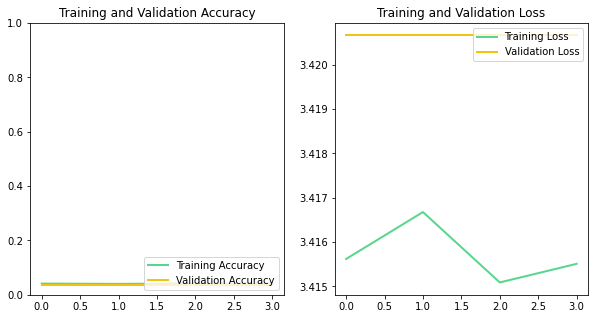

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plot_acc_loss(acc, val_acc, loss, val_loss)